<a href="https://colab.research.google.com/github/WEBSTERMASTER777/siamese-triplet/blob/master/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My\ Drive/Colab Notebooks
!ls

/content/gdrive/My Drive/Colab Notebooks
 archive_full.zip
 archive_full.zip.1
 bestmodel.pt
 cats_vs_dog.ipynb
'CIFAR10CNN (1).ipynb'
 CIFAR10CNN2.ipynb
 CIFAR10CNN.ipynb
 CIFAR10.ipynb
 CIFAR10TLVGG16.ipynb
 CIFAR10VGG16.ipynb
 CNNmodelNLLloss.pt
 CPUvsGPU.ipynb
'EncoderDecoder (1).ipynb'
 EncoderDecoder.ipynb
 GUN.ipynb
 ImageNet.ipynb
 KNN.ipynb
 Kuznyechik.ipynb
 LeNet5.ipynb
'MNIST<class '\''triplettorch.loss.HardNegativeTripletMiner'\''>.png'
'model_save_name '
 my_path.pt
 News.ipynb
 OpenCV.ipynb
 pdd
 Pi.ipynb
 PyTorchImageNet.ipynb
 Pytorch.ipynb
 PyTorchTutorial.ipynb
 training2.ipynb
 triplet.ipynb
 TripletLoss2varRabotaet.ipynb
 TripletLossMnist.ipynb
 TripletLossPashavar.ipynb
 TripletLossVar3.ipynb
 triplet.pt
 tripletweits.pt
 Untitled
 Untitled0.ipynb
'Untitled (1)'
 Untitled10.ipynb
 Untitled11.ipynb
 Untitled12.ipynb
 Untitled13.ipynb
 Untitled14.ipynb
 Untitled15.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 Untitled4.ipynb
 Untitled5.ipynb
 Untitled6.i

In [0]:
# !pip3 install triplettorch

In [0]:
import numpy as np
import torch
import time
import os

from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from torchvision import transforms
from torch import nn
# from triplettorch import HardNegativeTripletMiner
# from triplettorch import AllTripletMiner
# from torch.utils.data import DataLoader
# from triplettorch import TripletDataset
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

import torch.nn as nn
import numpy as np
import torch

In [0]:
import random
random.seed(0);
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

In [0]:
# !wget http://pdd.jinr.ru/archive_full.zip

In [7]:
!unzip archive_full.zip -d pdd

Archive:  archive_full.zip
   creating: pdd/Corn/Eyespot/
  inflating: pdd/Corn/Eyespot/296.jpg  
  inflating: pdd/Corn/Eyespot/313.jpg  
  inflating: pdd/Corn/Eyespot/304.jpg  
  inflating: pdd/Corn/Eyespot/294.jpg  
  inflating: pdd/Corn/Eyespot/303.jpg  
  inflating: pdd/Corn/Eyespot/300.jpg  
  inflating: pdd/Corn/Eyespot/306.jpg  
  inflating: pdd/Corn/Eyespot/286.jpg  
  inflating: pdd/Corn/Eyespot/284.jpg  
  inflating: pdd/Corn/Eyespot/309.jpg  
  inflating: pdd/Corn/Eyespot/292.jpg  
  inflating: pdd/Corn/Eyespot/312.jpg  
  inflating: pdd/Corn/Eyespot/285.jpg  
  inflating: pdd/Corn/Eyespot/283.jpg  
  inflating: pdd/Corn/Eyespot/295.jpg  
  inflating: pdd/Corn/Eyespot/287.jpg  
  inflating: pdd/Corn/Eyespot/305.jpg  
  inflating: pdd/Corn/Eyespot/291.jpg  
  inflating: pdd/Corn/Eyespot/299.jpg  
  inflating: pdd/Corn/Eyespot/297.jpg  
  inflating: pdd/Corn/Eyespot/311.jpg  
  inflating: pdd/Corn/Eyespot/307.jpg  
  inflating: pdd/Corn/Eyespot/310.jpg  
  inflating: pdd/Corn/

In [8]:
!ls pdd

Corn  Grape  Wheat


In [0]:
import numpy as np
import os

from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torchvision.datasets import ImageFolder


class AllCropsDataset(Dataset):
    def __init__(self, image_folder, subset='', transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        # data subset (train, test)
        self.subset = subset
        # store each crop data
        self.datasets = []
        self.crops = []
        self.samples = []
        self.imgs = []
        self.classes = []
        self.targets = []
        self.class_to_idx = {}
        # iterate over all folders 
        # with all crops
        for i, d in enumerate(os.listdir(image_folder)):
            self.crops.append(d)
            # full path to the folder
            d_path = os.path.join(image_folder, d, self.subset)
            # attribute name to set attribute 
            attr_name = '%s_ds' % d.lower()
            print("Load '%s' data" % attr_name)
            # set the attribute with the specified name
            setattr(self, attr_name, ImageFolder(d_path))
            # add the dataset to datasets list
            self.datasets.append(getattr(self, attr_name))
            # get dataset attribute
            ds = getattr(self, attr_name)
            # add attr targets to the global targets
            ds_targets = [x+len(self.classes) for x in ds.targets]
            self.targets.extend(ds_targets)
            # add particular classes to the global classes' list
            ds_classes = []
            for c in ds.classes:
                new_class = '__'.join([d, c])
                self.class_to_idx[new_class] = len(self.classes) + ds.class_to_idx[c]
                ds_classes.append(new_class)
            self.classes.extend(ds_classes)
            # imgs attribute has form (file_path, target)
            ds_imgs, _ = zip(*ds.imgs)
            # images and samples are equal
            self.imgs.extend(list(zip(ds_imgs, ds_targets)))
            self.samples.extend(list(zip(ds_imgs, ds_targets)))
            
            
    def __len__(self):
        return len(self.samples)
      
      
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = self.datasets[0].loader(path)
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target
      

In [0]:
DATA_PATH = 'pdd'

def prepare_datasets():
    train_ds = AllCropsDataset(
        DATA_PATH, 
        subset='train',
        transform=transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            # transforms.Normalize([0.4352, 0.5103, 0.2836], [0.2193, 0.2073, 0.2047])]),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
          target_transform=torch.tensor)

    test_ds = AllCropsDataset(
        DATA_PATH, 
        subset='test',
        transform=transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        target_transform=torch.tensor)

    # print statistics
    print('Train size:', len(train_ds))
    print('Test size:', len(test_ds))
    print('Number of samples in the dataset:', len(train_ds))
    print('Crops in the dataset:', train_ds.crops)
    print('Total number of classes in the dataset:', len(train_ds.classes))
    print('Classes with the corresponding targets:')
    print(train_ds.class_to_idx)
    return train_ds, test_ds

    import numpy as np
import shutil
import os

from glob import glob
from tqdm import tqdm
# from tqdm.notebook import tqdm

TEST_SIZE = 0.2
RS = 42
def _remove_path_if_exists(path):
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)
        else:
            shutil.rmtree(path)

def _makedir_and_copy2(path, dirname, fnames):
    path_for_saving_files = os.path.join(path, dirname)
    os.makedirs(path_for_saving_files)

    for fname in fnames:
        shutil.copy2(fname, path_for_saving_files)

def datadir_train_test_split(origin_path, test_size, random_state=0):
    """Splits the data in directory on train and test.
    # Arguments
        origin_path: path to the original directory
        test_size: the size of test data fraction
    # Returns
        Tuple of paths: `(train_path, test_path)`.
    """
    print("\n\nSplit `%s` directory" % origin_path)
    print("Test size: %.2f" % test_size)
    print("Random state: {}".format(random_state))
    train_path = os.path.join(origin_path, 'train')
    test_path = os.path.join(origin_path, 'test')   
    _remove_path_if_exists(train_path)
    _remove_path_if_exists(test_path)

    try:
        subfolders = glob(os.path.join(origin_path, "*", ""))
        # if train/test split is already done
        if set(subfolders) == set(['train', 'test']):
            return (train_path, test_path)
        # if train/test split is required
        # recreate train/test folders
        os.makedirs(train_path)
        os.makedirs(test_path)

        for folder in tqdm(subfolders, total=len(subfolders), ncols=57):
            # collect all images
            img_fnames = []
            for ext in ["*.jpg", "*.png", "*jpeg"]:
                img_fnames.extend(
                    glob(os.path.join(folder, ext)))
            # set random state parameter
            rs = np.random.RandomState(random_state)
            # shuffle array
            rs.shuffle(img_fnames)
            # split on train and test
            n_test_files = int(len(img_fnames)*test_size)
            test_img_fnames = img_fnames[:n_test_files]
            train_img_fnames = img_fnames[n_test_files:]
            # copy train files into `train_path/folder`
            folder_name = os.path.basename(os.path.dirname(folder))
            _makedir_and_copy2(train_path, folder_name, train_img_fnames)
            # copy test files into `test_path/folder`
            _makedir_and_copy2(test_path, folder_name, test_img_fnames)

        for folder in subfolders:
            shutil.rmtree(folder)

    except:
        _remove_path_if_exists(train_path)
        _remove_path_if_exists(test_path)
        raise 
        
    return (train_path, test_path)
def split_on_train_and_test():
    for crop in os.listdir('pdd'):
        crop_path = os.path.join('pdd', crop)
        _ = datadir_train_test_split(crop_path, 
                                    test_size=0.2, 
                                    random_state=42)    

In [11]:
split_on_train_and_test()



Split `pdd/Corn` directory
Test size: 0.20
Random state: 42


100%|██████████████████████| 5/5 [00:01<00:00,  2.77it/s]




Split `pdd/Wheat` directory
Test size: 0.20
Random state: 42


100%|██████████████████████| 5/5 [00:01<00:00,  2.99it/s]




Split `pdd/Grape` directory
Test size: 0.20
Random state: 42


100%|██████████████████████| 5/5 [00:03<00:00,  1.64it/s]


In [12]:

BATCH_SIZE = 16


train_ds, test_ds = prepare_datasets() 
train_loader = torch.utils.data.DataLoader(train_ds, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_ds, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=BATCH_SIZE)

Load 'corn_ds' data
Load 'wheat_ds' data
Load 'grape_ds' data
Load 'corn_ds' data
Load 'wheat_ds' data
Load 'grape_ds' data
Train size: 494
Test size: 117
Number of samples in the dataset: 494
Crops in the dataset: ['Corn', 'Wheat', 'Grape']
Total number of classes in the dataset: 15
Classes with the corresponding targets:
{'Corn__Downy mildew': 0, 'Corn__Eyespot': 1, 'Corn__Healthy': 2, 'Corn__Northern leaf blight': 3, 'Corn__Southern rust': 4, 'Wheat__Black chaff': 5, 'Wheat__Brown rust': 6, 'Wheat__Healthy': 7, 'Wheat__Powdery mildew': 8, 'Wheat__Yellow rust': 9, 'Grape__Black rot': 10, 'Grape__Chlorosis': 11, 'Grape__Esca': 12, 'Grape__Healthy': 13, 'Grape__Powdery mildew': 14}


In [40]:
type(train_ds)

__main__.AllCropsDataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


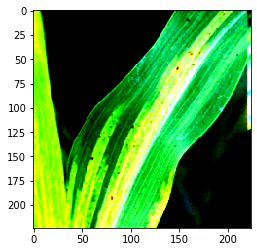

In [13]:
plt.imshow(train_ds[12][0].permute(1,2,0))

# Обычная сеть 1024 фичи

In [0]:
def simple_conv_block(in_channels, 
                      out_channels, 
                      kernel_size, 
                      stride, 
                      padding,
                      pool_size, 
                      pool_stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(pool_size, pool_stride))
import torch.nn.functional as F
class Model(nn.Module):
    '''Feature extractor'''
    def __init__(self, output_dim=1024):
        super(Model, self).__init__()
        self.output_dim = output_dim
        self.cnn1 = simple_conv_block(3, 32, 10, 1, 1, 2, 2)
        self.cnn2 = simple_conv_block(32, 64, 7, 1, 1, 2, 2)
        self.cnn3 = simple_conv_block(64, 128, 5, 1, 1, 2, 2)
        self.cnn4 = simple_conv_block(128, 256, 3, 1, 1, 2, 2)
        self.cnn5 = simple_conv_block(256, 512, 3, 1, 1, 2, 2)
        self.feature_proj = nn.Sequential(
          nn.Flatten(),
          nn.Linear(512*7*7, self.output_dim),
          nn.ReLU()
         
            )
        self.mlp = nn.Sequential(
          nn.Linear(self.output_dim, 512),
          nn.ReLU(),
          nn.Linear(512,256),
          nn.ReLU()
        )
        self.fc = nn.Sequential(
          # nn.Linear(self.output_dim, 15),
          nn.Linear(256, 15),
          nn.LogSoftmax()
          )
        
    
    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.feature_proj(x)
        x=self.mlp(x)
        x = self.fc(x)
        # print(x.shape)
        # x = self.cnn1(x)
        # x = self.cnn2(x)
        # x = self.cnn3(x)
        # x = self.cnn4(x)
        # x = self.cnn5(x)
        # print(x.shape)
        # x = x.view(x.size()[0], -1)
        # print(x.shape)
        # x = F.relu(self.feature_proj(x))
        # print(x.shape)
        # x = F.log_softmax(self.fc(x), dim=1)
        # x = x.view(x.size()[0], -1)
        # # x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        # x = self.fc1(x)
        # x = self.act3(x)
        # x = self.fc2(x)
        # x = self.act4(x)
        # x = self.fc3(x)
        # x=self.sm(x)
        
        return x
    

# Обычная сеть 2048 фич


In [0]:
def simple_conv_block(in_channels, 
                      out_channels, 
                      kernel_size, 
                      stride, 
                      padding,
                      pool_size, 
                      pool_stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(pool_size, pool_stride))
import torch.nn.functional as F



class Model(nn.Module):
    '''Feature extractor'''
    def __init__(self, output_dim=2048):
        super(Model, self).__init__()
        self.output_dim = output_dim
        self.cnn1 = simple_conv_block(3, 32, 10, 1, 1, 2, 2)
        self.cnn2 = simple_conv_block(32, 64, 7, 1, 1, 2, 2)
        self.cnn3 = simple_conv_block(64, 128, 5, 1, 1, 2, 2)
        self.cnn4 = simple_conv_block(128, 256, 3, 1, 1, 2, 2)
        self.cnn5 = simple_conv_block(256, 512, 3, 1, 1, 2, 2)
        self.cnn6 = simple_conv_block(512, 1024, 3, 1, 1, 2, 2)
        self.cnn7 = simple_conv_block(1024, output_dim, 3, 1, 1, 2, 2)
        # self.feature_proj = nn.Sequential(
        #   nn.Flatten(),
        #   nn.Linear(512*7*7, self.output_dim),
        #   nn.ReLU()
         
        #     )
        # self.mlp = nn.Sequential(
        #   nn.Linear(self.output_dim, 512),
        #   nn.ReLU(),
        #   nn.Linear(512,256),
        #   nn.ReLU()

        # )
        self.fc = nn.Sequential(
          # nn.Linear(1, 15),
          # nn.Linear(256, 15),
          # nn.Conv2d(self.output_dim, 15, 1, 1),
          # nn.ReLU(),
          # # nn.Linear(512*7*7, self.output_dim),
          nn.Flatten(),
          nn.Linear(self.output_dim, 15),
          nn.LogSoftmax(dim=1)
          )
        
    
    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.cnn6(x)
        x = self.cnn7(x)
        # x = self.feature_proj(x)
        # x=self.mlp(x)
        x = self.fc(x)
        return x

# Перенос обучения

In [16]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.5.1


In [0]:
try:
    import pycm
except:
    !pip install -q pycm
    import pycm

In [0]:
import torchbearer
from torchbearer.callbacks import imaging

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

make_grid = imaging.MakeGrid(torchbearer.INPUT, num_images=64, nrow=8, transform=inv_normalize)
make_grid = make_grid.on_test().to_pyplot().to_file('sample.png')

In [19]:
# model=Model()
# model.state_dict=Model().load_state_dict(torch.load('CNNmodelNLLloss.pt'))
# model = models.resnet50(pretrained=True)

# # Disable grad for all conv layers
# for param in model.parameters():
#     param.requires_grad = False
from torchvision import datasets, models, transforms

model =models.mobilenet_v2(pretrained=True)
for param in model.parameters():
     param.requires_grad = False
model.classifier[0] = nn.Linear(model.last_channel, 15)
model.classifier[1]=nn.LogSoftmax(dim=1)
from torchbearer.callbacks import EarlyStopping
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.NLLLoss()
# loss=torch.nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
import torchbearer
from torchbearer import Trial
from torchbearer.callbacks import Best

import sys
# if 'tensorboardX' in sys.modules:
#   import tensorboardX
#   from torchbearer.callbacks import TensorBoard
#   callbacks = [TensorBoard(write_batch_metrics=True)]
# else:
#   callbacks = []
checkpoint = Best('bestmodel.pt', monitor='val_acc', mode='max') 
# callbacks.append(make_grid)
stopping = EarlyStopping(monitor='val_acc', patience=5, mode='max')
from torchbearer.callbacks import PyCM
cm = PyCM().on_val().to_pyplot( title='Confusion Matrix: {epoch}')
# print_normalized_matrix()
# to_pyplot(normalize=True,)
# 

# Decay LR by a factor of 0.1 every 7 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [20]:
help(mobilenet_v2)

Help on function mobilenet_v2 in module torchvision.models.mobilenet:

mobilenet_v2(pretrained=False, progress=True, **kwargs)
    Constructs a MobileNetV2 architecture from
    `"MobileNetV2: Inverted Residuals and Linear Bottlenecks" <https://arxiv.org/abs/1801.04381>`_.
    
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr



In [36]:
print(model.last_channel)

1280


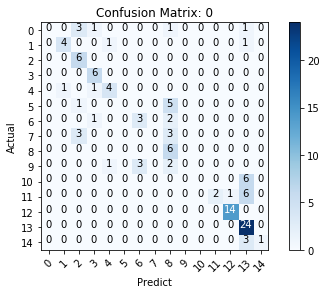

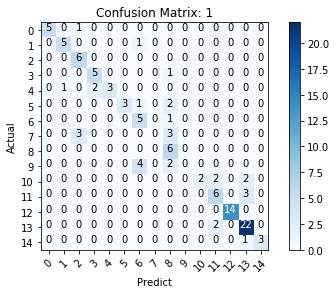

KeyboardInterrupt: ignored

In [21]:
trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=[checkpoint,cm]).to(device)
trial.with_train_generator(train_loader).with_val_generator(test_loader)
trial.to(device)
history = trial.run(epochs=70, verbose=2)

# Тест

In [0]:
model_test1 =models.mobilenet_v2(pretrained=True)
model_test1 = torch.nn.Sequential(*(list(model_test1.children())[:-1]))
# model_test1.classifier[1] = nn.Linear(model_test1.last_channel, 15)
for param in model_test1.parameters():
     param.requires_grad = False
    
model_test1.to(device)   
model_test1.eval()
test_x_numpy=[]
test_x1_numpy=[]
with torch.no_grad():
  for batch_idx, (inputs, targets) in enumerate(test_loader):
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model_test1(inputs).detach().cpu().numpy()
          targets= targets.detach().cpu().numpy()
          if (outputs.shape[0]==16):
            
            test_x_numpy.append(outputs)
test_x_numpy=np.vstack(test_x_numpy) 
print(test_x_numpy.shape)
# model_test1.fc = nn.Sequential(
#             nn.Linear(1280, 15),
#             nn.LogSoftmax(dim=1))
model_test1 =models.mobilenet_v2(pretrained=True)
# model_test1.classifier[0] = nn.Linear(model_test1.last_channel, 15)
# model_test1.classifier[1]=nn.LogSoftmax(dim=1)
model_test1.train()
trial = Trial(model_test1, optimizer, loss, metrics=['acc', 'loss'], callbacks=[checkpoint]).to(device)
trial.with_train_generator(train_loader).with_val_generator(test_loader)
trial.to(device)
history = trial.run(epochs=1, verbose=2)
model_test1 = torch.nn.Sequential(*(list(model_test1.children())[:-1]))
model_test1.eval()
with torch.no_grad():
  for batch_idx, (inputs, targets) in enumerate(test_loader):
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model_test1(inputs).detach().cpu().numpy()
          targets= targets.detach().cpu().numpy()
          if (outputs.shape[0]==16):
            
            test_x1_numpy.append(outputs)
test_x1_numpy=np.vstack(test_x1_numpy) 
print(test_x1_numpy.shape)
np.testing.assert_allclose(test_x_numpy,test_x1_numpy)

# Трансфер ленинг батч норм

In [0]:
model_test1 =models.mobilenet_v2(pretrained=True)
model_test1.classifier[0] = nn.Linear(model_test1.last_channel, 15)
model_test1.classifier[1]=nn.LogSoftmax(dim=1)
model_test1.to(device) 
# model_test1.train()
# trial = Trial(model_test1, optimizer, loss, metrics=['acc', 'loss'], callbacks=[checkpoint]).to(device)
# trial.with_train_generator(train_loader).with_val_generator(test_loader)
# trial.to(device)
# history = trial.run(epochs=1, verbose=2)
model_test1 = torch.nn.Sequential(*(list(model_test1.children())[:-1]))
model_test1.eval()
test_x_numpy=[]
train_x_numpy=[]
test_y_numpy=[]
train_y_numpy=[]

with torch.no_grad():
  for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs =  model_test1(inputs).detach().cpu().numpy()
            targets= targets.detach().cpu().numpy()
            if (outputs.shape[0]==16):
              train_x_numpy.append(outputs)
              train_y_numpy.append(targets)
train_x_numpy=np.vstack(train_x_numpy)             
train_y_numpy=np.hstack(train_y_numpy)

with torch.no_grad():
  for batch_idx, (inputs, targets) in enumerate(test_loader):
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model_test1(inputs).detach().cpu().numpy()
          targets= targets.detach().cpu().numpy()
          if (outputs.shape[0]==16):
            test_x_numpy.append(outputs)
            test_y_numpy.append(targets)
test_x_numpy=np.vstack(test_x_numpy) 
test_y_numpy=np.hstack(test_y_numpy)

x_train=torch.FloatTensor(train_x_numpy)
x_test=torch.FloatTensor(test_x_numpy)
y_train=torch.FloatTensor(train_y_numpy)
y_test=torch.FloatTensor(test_y_numpy)

# classifier = nn.Sequential(OrderedDict([
#                            ('fc1', nn.Linear(25088, 4096)),
#                            ('relu', nn.ReLU()),
#                            ('fc2', nn.Linear(4096, 102)),
#                            ('output', nn.LogSoftmax(dim=1))
#                            ]))
# classifier = nn.Sequential(
#              nn.Linear(1280, 15),
#              nn.LogSoftmax(dim=1))


# trial.with_train_generator(train_loader).with_val_generator(test_loader)
# trial.to(device)
# history = trial.run(epochs=70, verbose=2)



In [90]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [91]:
trial = Trial(cla, optimizer, loss, metrics=['acc', 'loss'], callbacks=[checkpoint]).to(device)
trial.with_train_data(x_train, y_train).with_val_data(x_test,y_test)
trial.to(device)
history = trial.run(epochs=50, verbose=2)

KeyboardInterrupt: ignored

In [96]:
class cl(torch.nn.Module):
  def __init__(self):
    super(cl,self).__init__()
    self.fc = nn.Sequential(
          nn.Flatten(),
          nn.Linear(8960*7, 15),
          nn.LogSoftmax(dim=1)
          )
        
    
    
   
    
  def forward(self,x): 
    x = x.mean(3).mean(2)
    x = self.fc(x)    
    return x
cla=cl() 
cla.to(device)

cl(
  (fc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=62720, out_features=15, bias=True)
    (2): LogSoftmax()
  )
)

In [0]:

  torch.save(model,'CNNmodelNLLloss.pt')
  torch.save(model.state_dict(),'CNNmodelNLLloss.pt')

In [0]:
model=model.load_state_dict(torch.load('bestmodel.pt'))


In [0]:
model.eval()

In [0]:
model = torch.nn.Sequential(*(list(model.children())[:-1]))

In [0]:
model
# from torchsummary import summary
# summary(model, input_size=(3, 256, 256))
# model(torch.rand(1, 3, 256, 256).to(device)).shape

In [0]:
print(history)

# Перевод в Numpy

In [0]:

# for img in train_ds:
#   print(img)
#   ipt=torch.FloatTensor(img)
  
#   # ipt.unsqueeze_(0)
from tqdm import tqdm
# from tqdm.notebook import tqdm
# i=0
from sklearn import metrics 
from sklearn.neighbors import KNeighborsClassifier
count=0
scorsum=0
train_x_numpy=[]
train_y_numpy=[]
with torch.no_grad():
  for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).detach().cpu().numpy()
            targets= targets.detach().cpu().numpy()
           
            if (outputs.shape[0]==16):
              print(outputs.shape)
              print(outputs.reshape(2048,16).shape)
              print(targets.shape)
            # knn=KNeighborsClassifier(n_neighbors=1)
            # knn.fit(outputs,targets)
              train_x_numpy.append(outputs.reshape(2048,16).transpose())
              train_y_numpy.append(targets)
test_x_numpy=[]
test_y_numpy=[]
with torch.no_grad():
  for batch_idx, (inputs, targets) in enumerate(test_loader):
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs).detach().cpu().numpy()
          targets= targets.detach().cpu().numpy()
            # y_pred=knn.predict(outputs)
            # scor=metrics.accuracy_score(targets,y_pred)
            
            # scorsum=scorsum+scor
            # count=count+1
          if (outputs.shape[0]==16):
            
            test_x_numpy.append(outputs.reshape(2048,16).transpose())
            test_y_numpy.append(targets)
            

# print(scorsum/count)
  # for b, batch in enumerate(train_loader):
  #   labels, data = 
  #   data         = torch.cat( [ datum for datum in   data ], axis = 0 )
  #   labels       = torch.cat( [ label for label in labels ], axis = 0 )
  #   embeddings   = model( data.cuda( ) ).detach( ).cpu( ).numpy( )
  #   labels       = labels.numpy( )
  #   test_embeddings.append( embeddings )
  #   test_labels.append( labels )

# while i < len(train_ds):
#   ipt= torch.FloatTensor(train_ds[i][0]).to(device)
#   ipt.unsqueeze_(0)
#   probs = torch.exp(model.forward(ipt))
#   probsTrainNP=probs.cpu().detach().numpy()
#   TrainNP=np.append(TrainNP,probsTrainNP)
#   # print(probsTrainNP)
#   i=i+1


In [0]:
print(len(train_loader))
# type(like_x_list)
# outputs.shape
# outputs.reshape(1024,5).shape
print(len(train_ds))
outputs.shape[0]

In [0]:
from sklearn.preprocessing import normalize
import sklearn.preprocessing 
train_x_numpy=normalize(np.vstack(train_x_numpy),norm='l2')
train_y_numpy=np.hstack(train_y_numpy)
test_y_numpy=np.hstack(test_y_numpy)
test_x_numpy=normalize(np.vstack(test_x_numpy),norm='l2')
print(train_y_numpy.shape)
print(train_x_numpy.shape)

print(test_y_numpy.shape)
print(test_x_numpy.shape)

# X = normalize(numpy.vstack([X_0, X_1]), norm='l2')

In [0]:
# from numpy import array
# data = [[[[11, 22],
# 		[33, 44],
# 		[55, 66]]]]
# data=array(data)
# data.shape
# data.reshape(3,2).sh
print(type(train_y_numpy))
print(train_y_numpy.shape)
train_y_numpy

In [0]:
# like_x_list = [train_x_numpy(BATCH_SIZE, 2048).astype('float32') for _ in range(len(train_loader))]

In [0]:
# like_x_list = [np.random.rand(1, 1024).astype('float32') for _ in range(100)]

In [0]:
print (train_x_numpy.shape)
# print (train_x_numpy.reshape(-1,1).shape)
xreshpe=train_x_numpy.reshape(-1,1)
print(xreshpe.shape)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
# train_x_numpy=[np.random.rand(, 1024).astype('float32') for _ in range(100)]


# x_train_reshape=train_x_numpy.numpy().reshape(-1,1)
# x_train_reshape=train_x_numpy.
# y_train_reshape=train_y_numpy.reshape(-1,1)
# np.asarray(train_x_numpy).reshape(-1,1)
from sklearn import metrics 

# k_range=range(1,26)
k=1
scores={}
scores_list=[]
# for k in k_range:
knn=KNeighborsClassifier(n_neighbors=k,metric=cosine_similarity)
# knn.fit(np.asarray(train_x_numpy).reshape(-1,1),np.asarray (train_y_numpy).reshape(-1,1))
knn.fit(train_x_numpy,train_y_numpy.reshape(-1,1))
y_pred=knn.predict(test_x_numpy)
scores[k]=metrics.accuracy_score(test_y_numpy,y_pred)

print(scores[k])

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cosine
# train_x_numpy=[np.random.rand(, 1024).astype('float32') for _ in range(100)]


# x_train_reshape=train_x_numpy.numpy().reshape(-1,1)
# x_train_reshape=train_x_numpy.
# y_train_reshape=train_y_numpy.reshape(-1,1)
# np.asarray(train_x_numpy).reshape(-1,1)
from sklearn import metrics 

# k_range=range(1,26)
k=1
scores={}
scores_list=[]
# for k in k_range:
knn=KNeighborsClassifier(n_neighbors=k,metric=cosine)
# knn.fit(np.asarray(train_x_numpy).reshape(-1,1),np.asarray (train_y_numpy).reshape(-1,1))
knn.fit(train_x_numpy,train_y_numpy)
y_pred=knn.predict(test_x_numpy)
scores[k]=metrics.accuracy_score(test_y_numpy,y_pred)

print(scores[k])

In [0]:
scores

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier()

boost.fit(train_x_numpy,train_y_numpy)
y_pred = boost.predict(test_x_numpy)
acc=metrics.accuracy_score(test_y_numpy,y_pred)

In [0]:
print(acc)

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y_numpy, y_pred)